In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob

from keras.models import load_model

In [13]:
#constants
IMG_W, IMG_H, IMG_C = (160, 160, 3)

In [2]:
import cv2 
import numpy as np
import mtcnn
from model import InceptionResNetV2
from training import normalize,l2_normalizer
from scipy.spatial.distance import cosine
from huggingface_hub import from_pretrained_keras
import pickle
import dlib

d:\Programming\DataScienceProjects\face-recognition-verification\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
confidence_t=0.9
recognition_t=0.35
required_size = (160,160)

In [75]:
def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

def get_encode(face_encoder, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = face_encoder.predict(np.expand_dims(face, axis=0))[0]
    return encode


def load_pickle(path):
    with open(path, 'rb') as f:
        encoding_dict = pickle.load(f)
    return encoding_dict

def detect(img ,detector,encoder,encoding_dict):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)
    names = []
    distances = []
    for res in results:
        if res['confidence'] < confidence_t:
            continue
        print(res)
        face, pt_1, pt_2 = get_face(img_rgb, res['box'])
        encode = get_encode(encoder, face, required_size)
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
        
        name = 'unknown'
        distance = float("inf")
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist
        names.append(name)
        distances.append(distance)
        if name == 'unknown':
            cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
            cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        else:
            cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
            cv2.putText(img, name, (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 200, 200), 2)
    return img, names, distances

def verify(img1,img2,detector,encoder):
        img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        results1 = detector.detect_faces(img1_rgb)
        results2 = detector.detect_faces(img2_rgb)
        
        for res1 in results1:
            for res2 in results2:
                if res1['confidence'] < confidence_t or res2['confidence'] < confidence_t:
                    continue
                face1, pt_11, pt_12 = get_face(img1_rgb, res1['box'])
                face2, pt_21, pt_22 = get_face(img2_rgb, res2['box'])
                encode1 = get_encode(encoder,face1, required_size)
                encode2 = get_encode(encoder,face2, required_size)
                encode1 = l2_normalizer.transform(encode1.reshape(1, -1))[0]
                encode2 = l2_normalizer.transform(encode2.reshape(1, -1))[0]
                distance = cosine(encode1, encode2)
                name = 'unknown'
                if distance < recognition_t:
                    name = 'matched'
                    cv2.rectangle(img1, pt_11, pt_12, (0, 255, 0), 2)
                    cv2.putText(img1, name , (pt_11[0], pt_11[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)
                    cv2.rectangle(img2, pt_21, pt_22, (0, 255, 0), 2)
                    cv2.putText(img2, name , (pt_21[0], pt_21[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)
                # else:
                #     name = 'unverified'
                #     cv2.rectangle(img1, pt_11, pt_12, (0, 0, 255), 2)
                #     cv2.putText(img1, name , (pt_11[0], pt_11[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)
                #     cv2.rectangle(img2, pt_21, pt_22, (0, 0, 255), 2)
                #     cv2.putText(img2, name , (pt_21[0], pt_21[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)

        return img1, img2, distance

In [46]:
required_shape = (160,160)
face_encoder = InceptionResNetV2()
path_m = "../model/keras-facenet/weights/facenet_keras_weights.h5"
face_encoder.load_weights(path_m)
# model = from_pretrained_keras("keras-io/lowlight-enhance-mirnet", compile=False)
encodings_path = '../model/encodings_updated.pkl'
lfw_encodings_path = '../model/lfw.pkl'
dlib_encodings_path = '../model/dlib_encoding.pkl'
face_detector = mtcnn.MTCNN()
encoding_dict = load_pickle(encodings_path)
lfw_dict = load_pickle(lfw_encodings_path)
dlib_dict = load_pickle(dlib_encodings_path)

### contour Testing

In [41]:
dlib_detector = dlib.get_frontal_face_detector()
dlib_predictor = dlib.shape_predictor('../model/dlib_models/shape_predictor_68_face_landmarks.dat')
dlib_encoder = dlib.face_recognition_model_v1('../model/dlib_models/dlib_face_recognition_resnet_model_v1.dat')

In [88]:
def drawPoints(image, faceLandmarks, startpoint, endpoint, isClosed=False):
    points = []
    for i in range(startpoint, endpoint+1):
        point = [faceLandmarks.part(i).x, faceLandmarks.part(i).y]
        points.append(point)

    points = np.array(points, dtype=np.int32)
    cv2.polylines(image, [points], isClosed, (255, 0, 0), thickness=2, lineType=cv2.LINE_8)

def facePoints(image, faceLandmarks):
    assert(faceLandmarks.num_parts == 68)
    drawPoints(image, faceLandmarks, 0, 16)           # Jaw line
    drawPoints(image, faceLandmarks, 17, 21)          # Left eyebrow
    drawPoints(image, faceLandmarks, 22, 26)          # Right eyebrow
    drawPoints(image, faceLandmarks, 27, 30)          # Nose bridge
    drawPoints(image, faceLandmarks, 30, 35, True)    # Lower nose
    drawPoints(image, faceLandmarks, 36, 41, True)    # Left eye
    drawPoints(image, faceLandmarks, 42, 47, True)    # Right Eye
    drawPoints(image, faceLandmarks, 48, 59, True)    # Outer lip
    drawPoints(image, faceLandmarks, 60, 67, True)    # Inner lip

rectangles[[(130, 164) (439, 474)]]
<class 'numpy.ndarray'>
Deepanshu Anand
0.9783899811725952


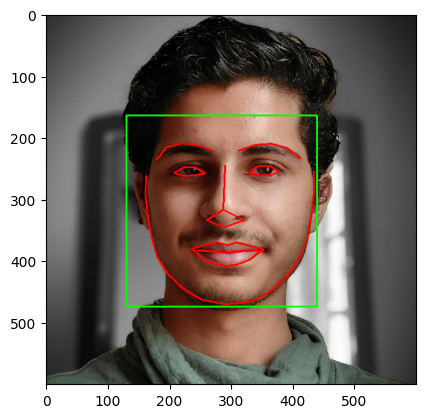

In [89]:
img_path = '../data/test/deepanshu 1.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = dlib_detector(img, 0)
print(faces)
for face in faces:
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()


    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
    shape = dlib_predictor(img, face)

    encode = np.array(dlib_encoder.compute_face_descriptor(img, shape))
    print(type(encode))
    
    name = 'unknown'
    distance = float("inf")
    for db_name, db_encode in dlib_dict.items():
        dist = cosine(db_encode, encode)
        if dist < recognition_t and dist < distance:
            name = db_name
            distance = dist
    print(name)
    print(1- distance)
    facePoints(img, shape)

plt.imshow(img)

1/1 [==============================] - 0s 42ms/step
{'box': [660, 98, 198, 241], 'confidence': 0.9990634322166443, 'keypoints': {'left_eye': (712, 184), 'right_eye': (804, 175), 'nose': (759, 226), 'mouth_left': (725, 283), 'mouth_right': (803, 277)}}
1/1 [==============================] - 0s 48ms/step
['Deepanshu Anand']
[0.28660887479782104]


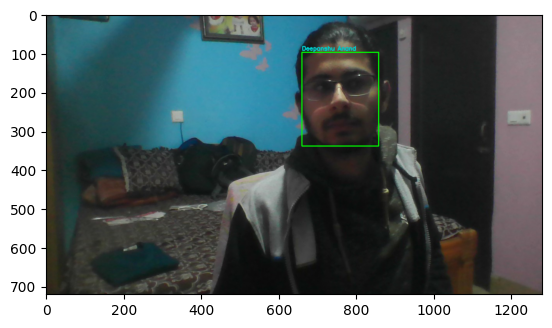

In [90]:
img_path = '../data/test/test_deep.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, names, distances = detect(img, face_detector, face_encoder, encoding_dict)
print(names)
print(distances)
plt.imshow(img)

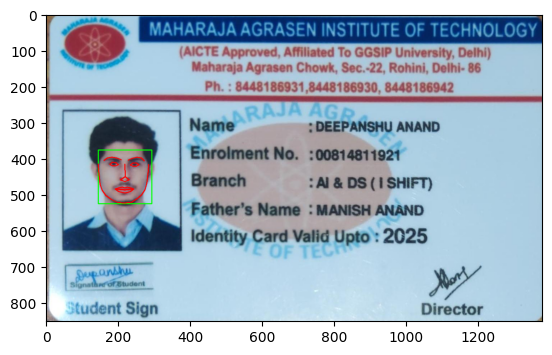

In [91]:
img1 = '../data/test/college_id.jpg'
img2 = '../data/test/deepanshu 1.jpg'
img1 = cv2.imread(img1)
img2 = cv2.imread(img2)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

face1 = dlib_detector(img1, 0)
for face in face1:
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()


    cv2.rectangle(img1, (x1,y1), (x2,y2), (0,255,0), 2)
    shape = dlib_predictor(img1, face)

    encode1 = np.array(dlib_encoder.compute_face_descriptor(img1, shape))
    facePoints(img1, shape)
    plt.imshow(img1)

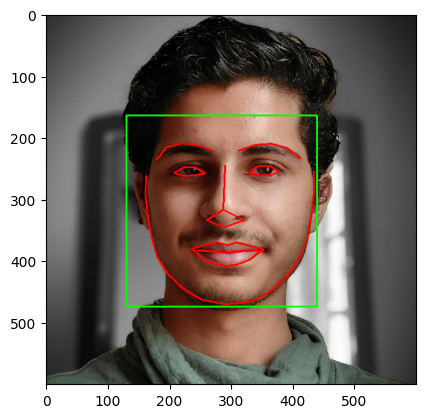

In [92]:
face2 = dlib_detector(img2, 0)
for face in face2:
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()


    cv2.rectangle(img2, (x1,y1), (x2,y2), (0,255,0), 2)
    shape = dlib_predictor(img2, face)

    encode2 = np.array(dlib_encoder.compute_face_descriptor(img2, shape))
    facePoints(img2, shape)
    plt.imshow(img2)

In [66]:
dist = cosine(encode1, encode2)
print(dist)

0.046006250956251105


### Low Light

In [8]:
SIGMA_LIST = [15, 80, 250]
ALPHA = 125.0
BETA = 46.0
G = 5.0
OFFSET = 25.0 

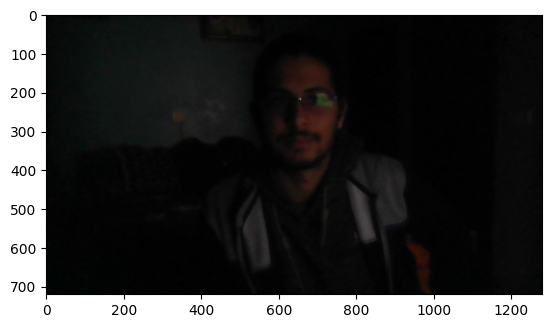

In [8]:
test_image = '../data/test/low_light_4.jpg'
img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img,names, distance = detect(img, face_detector, face_encoder, encoding_dict)
# print(distance)
# plt.title(f'{names}')
plt.imshow(img)

In [18]:
# from retinex import MSRCR
# test_image = '../data/test/low_light_4.jpg'
# img = cv2.imread(test_image)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# msrcr_img = MSRCR(img,SIGMA_LIST,ALPHA,BETA,G,OFFSET)
# image = keras.utils.img_to_array(img)
# image = image.astype("float32") / 255.0
# image = np.expand_dims(image, axis=0)
# output = model.predict(image)
# output_image = output[0] * 255.0
# output_image = output_image.clip(0, 255)
# output_image = output_image.reshape(
#     (np.shape(output_image)[0], np.shape(output_image)[1], 3)
# )
# output_image = np.uint32(output_image)

# print(distance)
# plt.title(f'{names}')
# plt.imshow(img[:,:,::-1])


1/1 [==============================] - 0s 49ms/step
{'box': [553, 111, 199, 283], 'confidence': 0.9987899661064148, 'keypoints': {'left_eye': (604, 223), 'right_eye': (701, 219), 'nose': (651, 273), 'mouth_left': (612, 326), 'mouth_right': (693, 319)}}
1/1 [==============================] - 0s 67ms/step
[0.31774044036865234]


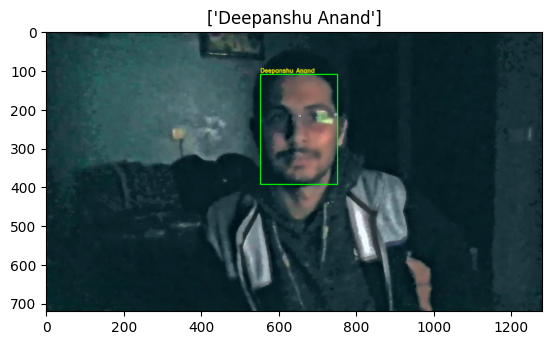

In [85]:
test_image = '../data/test/low_light_4_enhanced.jpg'
img = cv2.imread(test_image)
img,names, distance = detect(img, face_detector, face_encoder, encoding_dict)
print(distance)
plt.title(f'{names}')
plt.imshow(img[:,:,::-1])

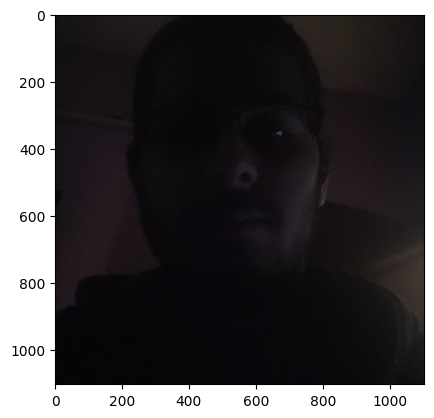

In [68]:
test_image = '../data/test/low_light_6.jpg'
img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

1/1 [==============================] - 0s 33ms/step
{'box': [254, 114, 526, 679], 'confidence': 0.9992285966873169, 'keypoints': {'left_eye': (427, 363), 'right_eye': (669, 359), 'nose': (558, 471), 'mouth_left': (464, 623), 'mouth_right': (652, 626)}}
1/1 [==============================] - 0s 59ms/step


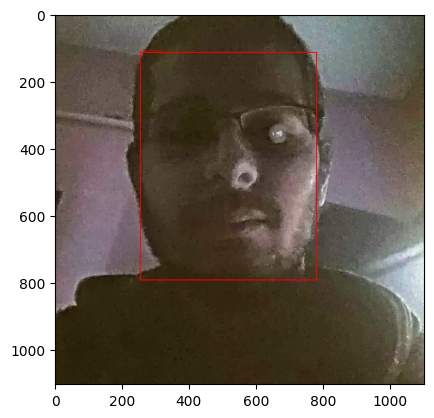

In [86]:
test_image = '../data/test/low_light_6_enhanced.jpg'
img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, names, distance = detect(img, face_detector, face_encoder, encoding_dict)
# print(faces)
plt.imshow(img[:,:,::-1])

### One to Many Recognition

1/1 [==============================] - 0s 29ms/step
[0.18463361263275146]


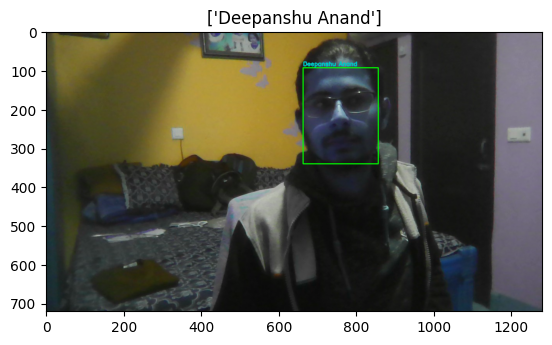

In [11]:
test_image = '../data/test/test_deep.jpg'
img = cv2.imread(test_image)
img,names, distance = detect(img, face_detector, face_encoder, encoding_dict)
print(distance)
plt.title(f'{names}')
plt.imshow(img)

1/1 [==============================] - 0s 42ms/step
[0.14579635858535767]


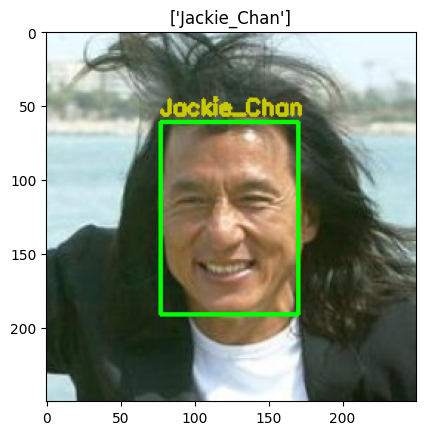

In [23]:
test_image = '../data/lfw/Jackie_Chan/Jackie_Chan_0013.jpg'
img = cv2.imread(test_image)
img,names, distance = detect(img, face_detector, face_encoder, lfw_dict)
print(distance)
plt.title(f'{names}')
plt.imshow(img[:,:,::-1])

### Many to Many Recognition

1/1 [==============================] - 0s 60ms/step
[0.23114615678787231, inf, inf, inf]


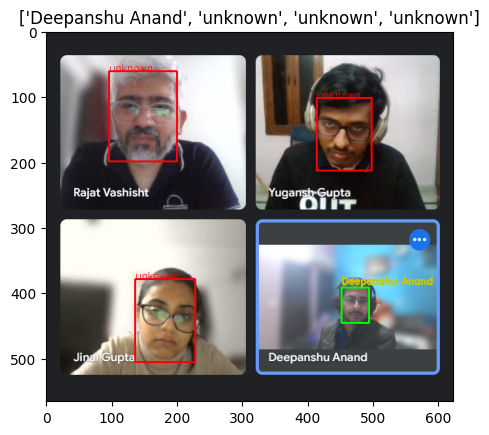

In [13]:
test_image = '../data/test/Screenshot 2024-01-29 200450.png'
img = cv2.imread(test_image)
img,names, distance = detect(img, face_detector, face_encoder, encoding_dict)
print(distance)
plt.title(f'{names}')
plt.imshow(img[:,:,::-1])

## Verification

### One to One

1/1 [==============================] - 0s 46ms/step


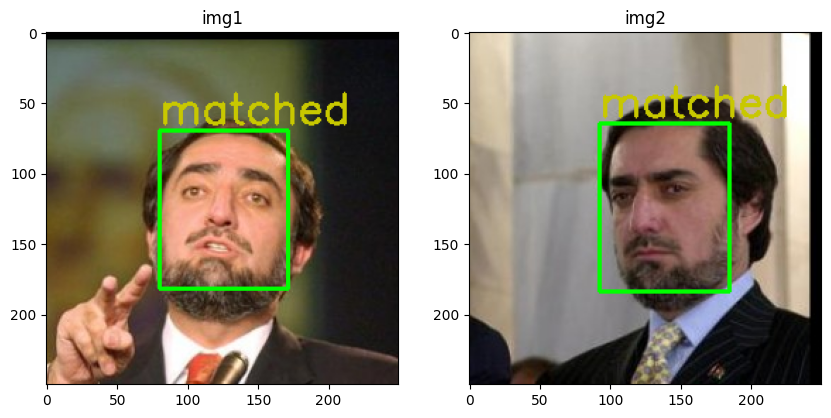

In [15]:
img1 = cv2.imread('../data/lfw/Abdullah/Abdullah_0002.jpg')
img2 = cv2.imread('../data/lfw/Abdullah/Abdullah_0004.jpg')

img1, img2, distance = verify(img1,img2, face_detector, face_encoder)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('img1')
plt.imshow(img1[:,:,::-1])
plt.subplot(122)
plt.title('img2')
plt.imshow(img2[:,:,::-1])
plt.show()

1/1 [==============================] - 0s 41ms/step
0.15439224243164062


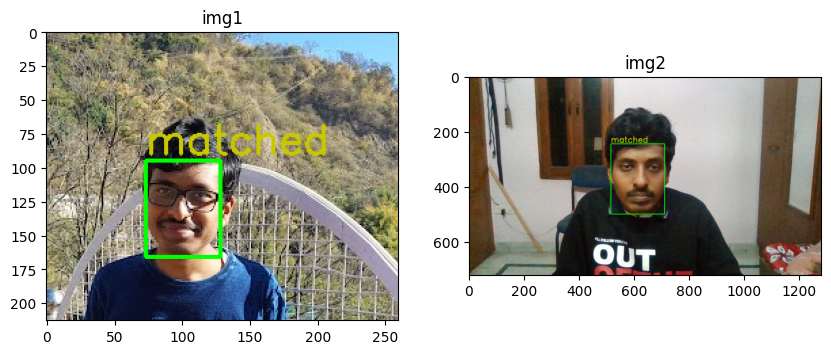

In [26]:
img1 = cv2.imread('../data/test/yug1.jpg')
img2 = cv2.imread('../data/test/yug2.jpg')

img1, img2, distance = verify(img1,img2, face_detector, face_encoder)
print(distance)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('img1')
plt.imshow(img1[:,:,::-1])
plt.subplot(122)
plt.title('img2')
plt.imshow(img2[:,:,::-1])
plt.show()

1/1 [==============================] - 0s 36ms/step
0.15198993682861328


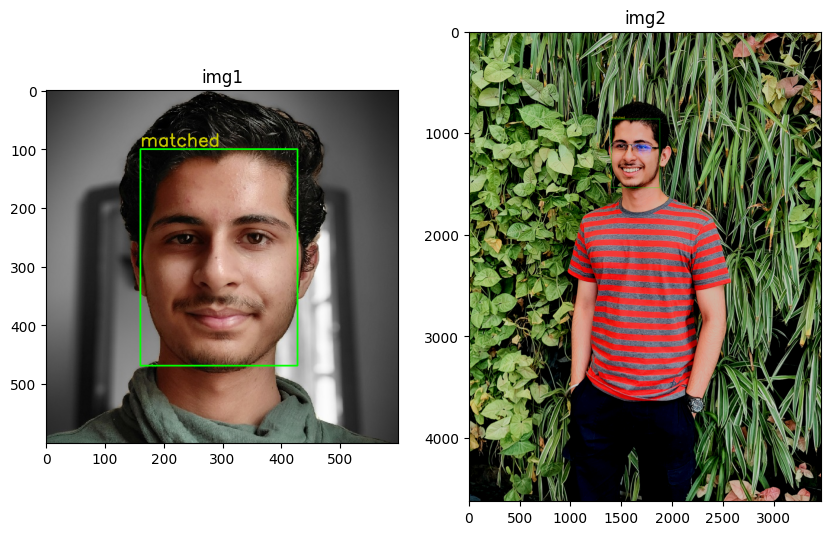

In [22]:
img1 = cv2.imread('../data/test/deepanshu 1.jpg')
img2 = cv2.imread('../data/test/deepanshu.jpg')

img1, img2, distances = verify(img1,img2, face_detector, face_encoder)

print(distances)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('img1')
plt.imshow(img1[:,:,::-1])
plt.subplot(122)
plt.title('img2')
plt.imshow(img2[:,:,::-1])

plt.show()

### Many to One

1/1 [==============================] - 0s 47ms/step


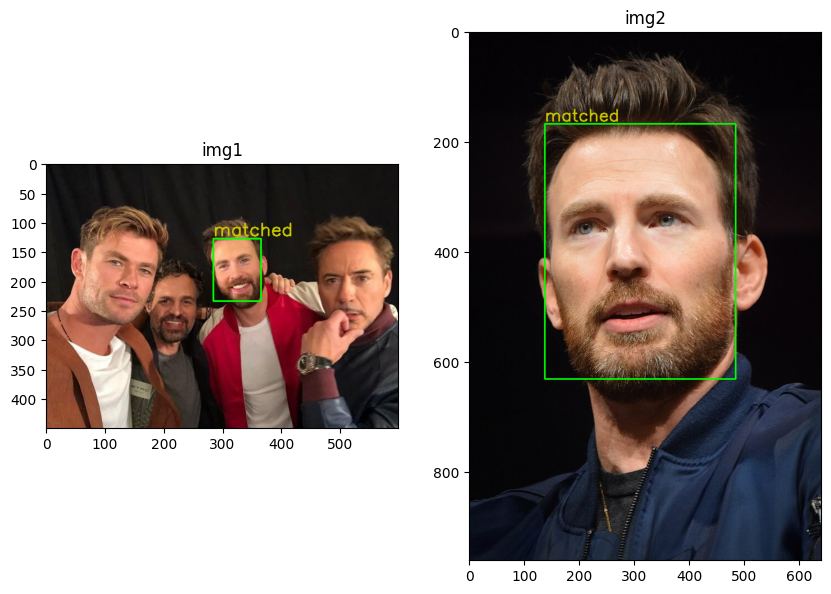

In [ ]:
img1 = cv2.imread('../data/test/chris-chris-robert.jpg')
img2 = cv2.imread('../data/test/ChrisEvans2023.jpg')

img1, img2 = verify(img1,img2, face_detector, face_encoder)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('img1')
plt.imshow(img1[:,:,::-1])
plt.subplot(122)
plt.title('img2')
plt.imshow(img2[:,:,::-1])
plt.show()

## Live

In [31]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detector.detect_faces(frame_rgb)
    for res in results:
        if res['confidence'] < confidence_t:
            continue
        face, pt_1, pt_2 = get_face(frame_rgb, res['box'])
        encode = get_encode(face_encoder,face, required_size)
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
        name = 'unknown'

        distance = float("inf")
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist

        if name == 'unknown':
            cv2.rectangle(frame, pt_1, pt_2, (0, 0, 255), 2)
            cv2.putText(frame, name, pt_1, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        else:
            cv2.rectangle(frame, pt_1, pt_2, (0, 255, 0), 2)
            cv2.putText(frame, name , (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)

    cv2.imshow('img', frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 47ms/step


## Video

In [19]:
def video_recognition(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detector.detect_faces(frame_rgb)
        for res in results:
            if res['confidence'] < confidence_t:
                continue
            face, pt_1, pt_2 = get_face(frame_rgb, res['box'])
            encode = get_encode(face_encoder,face, required_size)
            encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
            name = 'unknown'

            distance = float("inf")
            for db_name, db_encode in lfw_dict.items():
                dist = cosine(db_encode, encode)
                if dist < recognition_t and dist < distance:
                    name = db_name
                    distance = dist
            print(distance)
            if name == 'unknown':
                cv2.rectangle(frame, pt_1, pt_2, (0, 0, 255), 2)
                cv2.putText(frame, name, pt_1, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
            else:
                cv2.rectangle(frame, pt_1, pt_2, (0, 255, 0), 2)
                cv2.putText(frame, name , (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)

        cv2.imshow('img', frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [20]:
VID_PATH = '../data/test/yugansh.mp4'
video_recognition(VID_PATH)

1/1 [==============================] - 0s 44ms/step
inf
1/1 [==============================] - 0s 43ms/step
inf
1/1 [==============================] - 0s 45ms/step
inf
1/1 [==============================] - 0s 47ms/step
inf
1/1 [==============================] - 0s 47ms/step
inf
1/1 [==============================] - 0s 46ms/step
inf
1/1 [==============================] - 0s 41ms/step
inf
1/1 [==============================] - 0s 53ms/step
inf
1/1 [==============================] - 0s 42ms/step
inf
1/1 [==============================] - 0s 46ms/step
inf
1/1 [==============================] - 0s 42ms/step
inf
1/1 [==============================] - 0s 50ms/step
inf
1/1 [==============================] - 0s 49ms/step
inf
1/1 [==============================] - 0s 56ms/step
inf
1/1 [==============================] - 0s 47ms/step
inf
1/1 [==============================] - 0s 44ms/step
inf
1/1 [==============================] - 0s 52ms/step
inf
1/1 [==============================] - 0s 50ms/s